# Simple XG and McDavid study

In [256]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import requests
import seaborn as sns
from matplotlib.pyplot import imshow
from PIL import Image
from tqdm import tqdm
pd.set_option('display.max_columns', 500)

# Extract data for season 2020-2021

In [3]:
# Set up the API call variables
game_data_list = []
year = '2020'
season_type = '02' 
max_game_ID = 869#1290

# Loop over the counter and format the API call
for i in tqdm(range(1,max_game_ID)):
    r = requests.get(url='https://statsapi.web.nhl.com/api/v1/game/'
        + year + season_type +str(i).zfill(4)+'/feed/live')
    #print('https://statsapi.web.nhl.com/api/v1/game/'
    #   + year + season_type +str(i).zfill(4)+'/feed/live')
    data = r.json()
    df = pd.json_normalize(data["liveData"]["plays"]["allPlays"])
    df.columns = [col.replace(".","_") for col in df.columns]
    cond1 = df["result_event"] == "Shot"
    cond2 = df["result_event"] == "Goal"
    
    df = df[cond1 | cond2]
    #df["distance"] = np.sqrt(df["coordinates_y"]**2 + (df["coordinates_x"] - 84)**2)
    #df["coordinates_x"] = np.abs(df["coordinates_x"])
    #df["angle"] = np.arctan((84 - df["coordinates_x"]) * 6 / ((84 - df["coordinates_x"])**2 + df["coordinates_y"]**2 - (6/2)**2))
    #df["angle"] = np.where(df["coordinates_x"] >= 84, 0, df["angle"])
    #df["angle_deg"] = df["angle"]*180/np.pi
    #df["distance_m"] = df["distance"]*0.3048
    df.reset_index(inplace=True, drop=True)
    
    df_active = pd.json_normalize(pd.json_normalize(df["players"])[0])
    df_active.columns = [col if len(col) == 1 else col.replace(".","_") for col in df_active.columns]
    df_active.rename(columns=({"playerType":"player_type_1", "player_id":"player_id_1"}), inplace=True)
    #df_active["player_id_1"] = df_active["player_id_1"].astype("int")
    df_active = df_active[["player_type_1", "player_id_1"]]
    #df_active["player_id_1"] = df_active["player_id_1"].astype("int")
    df_active.reset_index(inplace=True, drop=True)
    
    df = pd.concat([df, df_active], axis=1)
    
    game_data_list.append(df)

100%|█████████████████████████████████████████████████████████████████████████████| 868/868 [04:18<00:00,  3.36it/s]


Number of games

In [255]:
len(game_data_list)

868

In [6]:
game_data = pd.concat(game_data_list)

In [35]:
game_data.reset_index(drop=True, inplace=True)

Remove empty net goals or shots, as we dont want to generalize from these events

In [7]:
cond = game_data["result_emptyNet"] == True
game_data = game_data[~cond]
game_data.dropna(subset=["result_event"], inplace=True)
game_data["goal"] = np.where(game_data["result_event"] == "Goal", 1, 0)
print(game_data.shape)

(52150, 31)


Compute distance to goal, angle to goal center and "mouth" angle

In [41]:
game_data["coordinates_x_abs"] = np.abs(game_data["coordinates_x"])
game_data["coordinates_y_cor"] = np.where(game_data["coordinates_x"] < 0, -1*game_data["coordinates_y"], game_data["coordinates_y"])
#game_data["x_scaled"] = game_data["coordinates_x_abs"] / 100 * w
#game_data["y_scaled"] = (game_data["coordinates_y_cor"] + 42.5) / (2*42.5) * h


game_data["distance"] = np.sqrt(game_data["coordinates_y_cor"]**2 + (84 - game_data["coordinates_x_abs"])**2)
#game_data["coordinates_x"] = np.abs(df_mcd["coordinates_x"])
game_data["angle"] = np.arctan((84 - game_data["coordinates_x_abs"]) * 6 / ((84 - game_data["coordinates_x_abs"])**2 + game_data["coordinates_y_cor"]**2 - (6/2)**2))
game_data["angle2"] = np.arctan((3-np.abs(game_data["coordinates_y_cor"]))/(84 - game_data["coordinates_x_abs"])) + np.arctan((3+np.abs(game_data["coordinates_y_cor"]))/(84 - game_data["coordinates_x_abs"]))
game_data["angle"] = np.where(np.abs(game_data["coordinates_y_cor"]) <= 3, game_data["angle2"], game_data["angle"])
game_data["angle"] = np.where(game_data["coordinates_x_abs"] >= 84, 0, game_data["angle"])
game_data["angle_deg"] = game_data["angle"]*180/np.pi
    

Try a logistic regression model to predict Expected Goal(XG) value to try to evaluate players. As the NHL API data dont contain enough context for each event there is no point trying a complicated model. Basically we only we have coordinates for a shot. We dont know where the puck was previously or where other players are located.

Creating a model for XG based on just one season, especially the "Corona" season which were limited in number of games, can be questioned. Nevertheless, we just want to check if such a model makes "sense" especially keeping in mind we dont have enough context regarding each event.

Below a model is created based on the features angle(mouth angle), distance and x-coordinate. This acquires an AUC of about 0.73 which is at least better than a pure random model.

No effort is made considering evaluateing on a separate validation or test set. The reason is that we just want to test if model can learn to make a reasonable estimate of expected goal based on some basic dimensions related to coordinates on the ice.

In [76]:
cond = game_data["angle_deg"] > 0
test_model = smf.glm(formula="goal ~ angle + distance + coordinates_x_abs" , data=game_data[cond], 
#test_model = smf.glm(formula="goal ~ angle" , data=game_data, 
                       family=sm.families.Binomial()).fit()

In [77]:
test_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                   goal   No. Observations:                48352
Model:                            GLM   Df Residuals:                    48348
Model Family:                Binomial   Df Model:                            3
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -13345.
Date:                Wed, 10 Nov 2021   Deviance:                       26691.
Time:                        08:29:47   Pearson chi2:                 4.76e+04
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             3.3124      0.363      9.129      0.000       2.601       4.024
angle                -0.1506      0.055     -2.727      0.006      -0.259      -0.042
distance             -0.0971      0.004    -23.130      0.000      -0.105      -0.089
coordinates_x_abs    -0.0490      0.004    -12.231      0.000      -0.057      -0.041
=====================================================================================
"""

In [78]:
#game_data["xg"] = test_model.predict(game_data[["distance", "angle"]])
game_data["xg"] = test_model.predict(game_data[["angle", "distance", "coordinates_x_abs"]])

In [79]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(game_data["goal"], game_data["xg"], pos_label=1,)
auc(fpr, tpr)

0.7315084725197851

Create a mesh grid to be able to make a countour plot(heat map) of the XG value.

In [ ]:
y, x = np.meshgrid(np.linspace(-42, 42, 50), np.linspace(0, 40, 50))
angle = np.arctan(x * 6 / (x**2 + y**2 - (3)**2))
angle2 = np.arctan((3-np.abs(y))/(x)) + np.arctan((3+np.abs(y))/(x))
angle = np.where(np.abs(y) <= 3, angle2, angle)
angle = np.where(x == 0, 0, angle)
distance = np.sqrt(x**2 + y**2)

xg =  test_model.predict(angle)

C:\Users\9ja\AppData\Local\Temp/ipykernel_31156/737795303.py:3: RuntimeWarning: divide by zero encountered in true_divide
  angle2 = np.arctan((3-np.abs(y))/(x)) + np.arctan((3+np.abs(y))/(x))


In [115]:
xg = np.zeros((len(angle), len(angle)))
for i in tqdm(range(len(angle))):
    for j in range(len(angle)):
        #print(i,j)
        xg[i,j] = test_model.predict(pd.DataFrame([[angle[i,j], distance[i,j], x[i,j]]], columns=["angle", "distance", "coordinates_x_abs"])).values[0]

100%|███████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.36it/s]


In [106]:
angle_deg = angle*180/np.pi

In [107]:
xg = xg[:-1, :-1]

Plot the XG to see if it seems reasonable. Here one can see that distance and angle relative to the goal has an effect of the XG. The goal coordinates are located at x = 0 and between  -3 <= y <= 3. All the dimensions are in feet. From this figure it looks like the model generates reasonable XG values based on the coordinates were a shit is taken place.

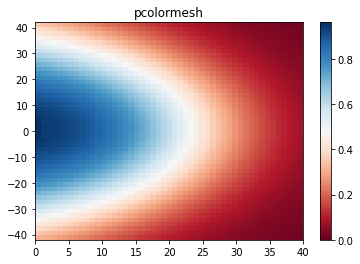

In [113]:
z_min, z_max = -np.abs(xg).max(), np.abs(xg).max()
fig, ax = plt.subplots()
c = ax.pcolormesh(x, y, xg, cmap='RdBu', vmin=0, vmax=z_max)
#c = ax.pcolormesh(x, y, angle_deg, cmap='RdBu', vmin=0, vmax=180)
ax.set_title('pcolormesh')
# set the limits of the plot to the limits of the data
ax.axis([x.min(), x.max(), y.min(), y.max()])
fig.colorbar(c, ax=ax)

plt.show()

Aggregate the player data based on player

In [244]:
df_sum = game_data.groupby("player_id_1").agg({"player_id_1":"count", "goal":"sum", "xg":["sum", "mean"], "distance":"mean"})
df_sum.columns = [f"{col[0]}_{col[1]}" for col in df_sum.columns]
df_sum.rename(columns=({"player_id_1_count":"shots"}), inplace=True)
df_sum.sort_values("shots")
df_sum.reset_index(inplace=True)
df_sum.rename(columns=({"player_id_1":"player_id", "goal_sum":"goal"}), inplace=True)
df_sum.head()

,player_id,shots,goal,xg_sum,xg_mean,distance_mean
0,8465009,67,2,2.422203,0.036152,47.926365
1,8466138,41,4,4.625620,0.112820,24.503338
2,8466139,55,4,7.447111,0.135402,19.265162
3,8469455,82,11,8.703111,0.106135,24.721801
4,8469459,3,1,0.227865,0.075955,30.840086


Extract player specific data for each player in the 2020-2021 season

In [131]:
player_ids = list(map(str, df_sum["player_id"].unique().tolist()))

In [133]:
# Get some player info such as name and position
player_list = []
for player in tqdm(player_ids):
    response = requests.get('https://statsapi.web.nhl.com/api/v1/people/' + player)
    df_player = pd.json_normalize(response.json()["people"][0])
    df_player["player_id"] = player
    player_list.append(df_player)
df_player2= pd.concat(player_list)
df_player2["player_id"] = df_player2["player_id"].astype("int")
df_player2.head()

100%|█████████████████████████████████████████████████████████████████████████████| 892/892 [03:57<00:00,  3.75it/s]


,id,fullName,link,firstName,lastName,primaryNumber,birthDate,currentAge,birthCity,birthCountry,nationality,height,weight,active,alternateCaptain,captain,rookie,shootsCatches,rosterStatus,currentTeam.id,currentTeam.name,currentTeam.link,primaryPosition.code,primaryPosition.name,primaryPosition.type,primaryPosition.abbreviation,player_id,birthStateProvince
0,8465009,Zdeno Chara,/api/v1/people/8465009,Zdeno,Chara,33,1977-03-18,44.0,Trencin,SVK,SVK,"6' 9""",250,True,False,False,False,L,Y,2.0,New York Islanders,/api/v1/teams/2,D,Defenseman,Defenseman,D,8465009,NaN
0,8466138,Joe Thornton,/api/v1/people/8466138,Joe,Thornton,19,1979-07-02,42.0,London,CAN,CAN,"6' 4""",220,True,False,False,False,L,I,13.0,Florida Panthers,/api/v1/teams/13,C,Center,Forward,C,8466138,ON
0,8466139,Patrick Marleau,/api/v1/people/8466139,Patrick,Marleau,12,1979-09-15,NaN,Aneroid,CAN,CAN,"6' 2""",215,False,NaN,NaN,False,L,Y,NaN,NaN,NaN,C,Center,Forward,C,8466139,SK
0,8469455,Jason Spezza,/api/v1/people/8469455,Jason,Spezza,19,1983-06-13,38.0,Toronto,CAN,CAN,"6' 3""",219,True,False,False,False,R,Y,10.0,Toronto Maple Leafs,/api/v1/teams/10,C,Center,Forward,C,8469455,ON
0,8469459,Mikko Koivu,/api/v1/people/8469459,Mikko,Koivu,9,1983-03-12,38.0,Turku,FIN,FIN,"6' 3""",213,True,False,False,False,L,N,29.0,Columbus Blue Jackets,/api/v1/teams/29,C,Center,Forward,C,8469459,NaN


In [134]:
# Get some player info such as stats
player_list = []
for player in tqdm(player_ids):
    response = requests.get('https://statsapi.web.nhl.com/api/v1/people/' + player + '/stats/?stats=statsSingleSeason&season=20202021')
    df_player = pd.json_normalize(response.json()["stats"][0]["splits"][0])
    df_player["player_id"] = player
    player_list.append(df_player)

100%|█████████████████████████████████████████████████████████████████████████████| 892/892 [04:08<00:00,  3.58it/s]


In [232]:
df_player = pd.concat(player_list)
df_player["player_id"] = df_player["player_id"].astype("int")

In [234]:
df_player.head()

,season,stat.timeOnIce,stat.assists,stat.goals,stat.pim,stat.shots,stat.games,stat.hits,stat.powerPlayGoals,stat.powerPlayPoints,stat.powerPlayTimeOnIce,stat.evenTimeOnIce,stat.penaltyMinutes,stat.faceOffPct,stat.shotPct,stat.gameWinningGoals,stat.overTimeGoals,stat.shortHandedGoals,stat.shortHandedPoints,stat.shortHandedTimeOnIce,stat.blocked,stat.plusMinus,stat.points,stat.shifts,stat.timeOnIcePerGame,stat.evenTimeOnIcePerGame,stat.shortHandedTimeOnIcePerGame,stat.powerPlayTimeOnIcePerGame,player_id,stat.ot,stat.shutouts,stat.ties,stat.wins,stat.losses,stat.saves,stat.powerPlaySaves,stat.shortHandedSaves,stat.evenSaves,stat.shortHandedShots,stat.evenShots,stat.powerPlayShots,stat.savePercentage,stat.goalAgainstAverage,stat.gamesStarted,stat.shotsAgainst,stat.goalsAgainst,stat.powerPlaySavePercentage,stat.shortHandedSavePercentage,stat.evenStrengthSavePercentage
0,20202021,1007:43,8.0,2.0,44.0,67.0,55,88.0,0.0,0.0,13:55,846:10,44,0.00,3.0,0.0,0.0,0.0,0.0,147:38,67.0,5.0,10.0,1213.0,18:19,15:23,02:41,00:15,8465009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,20202021,603:41,15.0,5.0,14.0,42.0,44,32.0,0.0,5.0,85:03,518:30,14,57.35,11.9,0.0,0.0,0.0,0.0,00:08,10.0,6.0,20.0,794.0,13:43,11:47,00:00,01:55,8466138,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,20202021,743:50,5.0,4.0,10.0,54.0,56,40.0,2.0,2.0,60:11,645:46,10,47.00,7.4,0.0,0.0,0.0,0.0,37:53,19.0,-9.0,9.0,1004.0,13:16,11:31,00:40,01:04,8466139,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,20202021,595:35,20.0,10.0,6.0,81.0,54,26.0,1.0,5.0,72:32,479:50,6,56.93,12.3,2.0,0.0,0.0,0.0,43:13,10.0,3.0,30.0,914.0,11:01,08:53,00:48,01:20,8469455,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,20202021,87:14,1.0,1.0,2.0,3.0,7,10.0,0.0,0.0,00:14,78:55,2,45.71,33.3,0.0,0.0,0.0,0.0,08:05,1.0,-2.0,2.0,120.0,12:27,11:16,01:09,00:02,8469459,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Merge in player data to our aggregated dataframe

In [246]:
df_sum = df_sum.merge(df_player2[["player_id", "fullName", "primaryPosition.type"]], on="player_id")
df_sum = df_sum.merge(df_player[["player_id", "stat.timeOnIce"]], on="player_id")


In [239]:
df_sum.head()

,player_id,shots,goal,xg_sum,xg_mean,distance_mean,fullName,primaryPosition.type,stat.timeOnIce
0,8465009,67,2,2.422203,0.036152,47.926365,Zdeno Chara,Defenseman,1007:43
1,8466138,41,4,4.625620,0.112820,24.503338,Joe Thornton,Forward,603:41
2,8466139,55,4,7.447111,0.135402,19.265162,Patrick Marleau,Forward,743:50
3,8469455,82,11,8.703111,0.106135,24.721801,Jason Spezza,Forward,595:35
4,8469459,3,1,0.227865,0.075955,30.840086,Mikko Koivu,Forward,87:14


Normalize XG by the number of minutes played in the season

In [247]:
df_sum["stat.timeOnIce"] = df_sum["stat.timeOnIce"].str.replace(":",".")
df_sum["stat.timeOnIce"] = df_sum["stat.timeOnIce"].astype("float")
df_sum["xg_norm"] = df_sum["xg_sum"] / df_sum["stat.timeOnIce"]
df_sum["goal_vs_xg"] = df_sum["goal"] - df_sum["xg_sum"]
df_sum["goal_vs_time"] = df_sum["goal"] / df_sum["stat.timeOnIce"]


Here is another "make sense" evaluation. We expect some "top" players to show up when we sort on our XG metrics. To remove outliers we filter out players with too low shot count. Its a bit relieving to see Auston Matthews at position 3 when sorting based on our normalized XG value(xg_norm). However we are still missing some quite significant players from this season. 

Here it maybe would have been interesing to normalize with time spent on offensive half or time spent when own team is in control.

In [241]:
cond = df_sum["shots"] > 15
df_sum[cond].sort_values("xg_norm", ascending=False).head(10)

,player_id,shots,goal,xg_sum,xg_mean,distance_mean,fullName,primaryPosition.type,stat.timeOnIce,xg_norm,goal_vs_xg
794,8480801,221,17,28.898867,0.130764,20.992307,Brady Tkachuk,Forward,1020.52,0.028318,-11.898867
245,8475848,106,14,13.960112,0.131699,19.873149,Brendan Gallagher,Forward,525.20,0.026581,0.039888
634,8479318,222,41,29.400659,0.132435,18.488260,Auston Matthews,Forward,1120.46,0.026240,11.599341
56,8471887,148,16,18.340197,0.123920,22.406839,Patric Hornqvist,Forward,738.28,0.024842,-2.340197
499,8477987,110,9,15.048368,0.136803,18.967485,Ryan Donato,Forward,630.05,0.023884,-6.048368
192,8475314,79,11,10.499056,0.132899,22.730727,Anders Lee,Forward,473.12,0.022191,0.500944
849,8481540,30,4,3.012426,0.100414,22.953483,Cole Caufield,Forward,139.36,0.021616,0.987574
157,8475166,163,19,21.937816,0.134588,18.947160,John Tavares,Forward,1019.02,0.021528,-2.937816
681,8479420,97,8,11.323103,0.116733,23.728571,Tage Thompson,Forward,527.10,0.021482,-3.323103
632,8479314,152,17,21.541823,0.141723,18.680303,Matthew Tkachuk,Forward,1016.45,0.021193,-4.541823


Below are some players that we would hope would end up higher up when we sort on xg_norm, i.e. top goal scorers season 20-21.

In [242]:
df_sum.sort_values("goal", ascending=False).head(10)

,player_id,shots,goal,xg_sum,xg_mean,distance_mean,fullName,primaryPosition.type,stat.timeOnIce,xg_norm,goal_vs_xg
634,8479318,222,41,29.400659,0.132435,18.488260,Auston Matthews,Forward,1120.46,0.026240,11.599341
543,8478402,198,31,26.148680,0.132064,18.443381,Connor McDavid,Forward,1240.36,0.021082,4.851320
643,8479337,156,31,18.163853,0.116435,21.470645,Alex DeBrincat,Forward,1068.04,0.017007,12.836147
471,8477934,166,29,16.096956,0.096970,24.854898,Leon Draisaitl,Forward,1242.33,0.012957,12.903044
551,8478420,174,27,17.464233,0.100369,25.641863,Mikko Rantanen,Forward,1035.44,0.016866,9.535767
609,8478864,157,27,17.674010,0.112573,23.187971,Kirill Kaprizov,Forward,1006.22,0.017565,9.325990
434,8477493,177,26,21.797727,0.123151,21.194325,Aleksander Barkov,Forward,1046.52,0.020829,4.202273
24,8470794,145,26,18.206520,0.125562,20.771857,Joe Pavelski,Forward,1065.14,0.017093,7.793480
539,8478398,167,26,18.512857,0.110855,22.796805,Kyle Connor,Forward,1049.21,0.017645,7.487143
59,8473419,141,25,16.702894,0.118460,23.007562,Brad Marchand,Forward,1002.15,0.016667,8.297106


Lets see which players performed the best in terms of the difference between their xg and the number of goals.

In [141]:
df_sum.sort_values("goal_vs_xg", ascending=False).head(10)

,player_id,shots,goal,xg_sum,xg_mean,fullName,primaryPosition.type,stat.timeOnIce,xg_norm,goal_vs_xg
471,8477934,166,29,16.096956,0.096970,Leon Draisaitl,Forward,1242.33,0.012957,12.903044
643,8479337,156,31,18.163853,0.116435,Alex DeBrincat,Forward,1068.04,0.017007,12.836147
634,8479318,222,41,29.400659,0.132435,Auston Matthews,Forward,1120.46,0.026240,11.599341
470,8477933,130,23,13.232664,0.101790,Sam Reinhart,Forward,1055.06,0.012542,9.767336
480,8477944,104,21,11.421002,0.109817,Jakub Vrana,Forward,750.21,0.015224,9.578998
597,8478550,108,18,8.426569,0.078024,Artemi Panarin,Forward,825.00,0.010214,9.573431
551,8478420,174,27,17.464233,0.100369,Mikko Rantanen,Forward,1035.44,0.016866,9.535767
609,8478864,157,27,17.674010,0.112573,Kirill Kaprizov,Forward,1006.22,0.017565,9.325990
416,8477444,102,19,10.263909,0.100627,Andre Burakovsky,Forward,799.53,0.012837,8.736091
27,8471214,183,24,15.473539,0.084555,Alex Ovechkin,Forward,877.35,0.017637,8.526461


Just sorting on xg_sum wet some more top scorers showing up.

In [143]:
df_sum.sort_values("xg_sum", ascending=False).head(10)

,player_id,shots,goal,xg_sum,xg_mean,fullName,primaryPosition.type,stat.timeOnIce,xg_norm,goal_vs_xg
634,8479318,222,41,29.400659,0.132435,Auston Matthews,Forward,1120.46,0.026240,11.599341
794,8480801,221,17,28.898867,0.130764,Brady Tkachuk,Forward,1020.52,0.028318,-11.898867
543,8478402,198,31,26.148680,0.132064,Connor McDavid,Forward,1240.36,0.021082,4.851320
157,8475166,163,19,21.937816,0.134588,John Tavares,Forward,1019.02,0.021528,-2.937816
434,8477493,177,26,21.797727,0.123151,Aleksander Barkov,Forward,1046.52,0.020829,4.202273
160,8475169,191,19,21.679910,0.113507,Evander Kane,Forward,1131.02,0.019168,-2.679910
632,8479314,152,17,21.541823,0.141723,Matthew Tkachuk,Forward,1016.45,0.021193,-4.541823
295,8476455,155,20,20.631620,0.133107,Gabriel Landeskog,Forward,1077.41,0.019149,-0.631620
19,8470638,181,22,19.832531,0.109572,Patrice Bergeron,Forward,983.59,0.020163,2.167469
406,8477404,141,22,19.792225,0.140370,Jake Guentzel,Forward,1134.58,0.017445,2.207775


## Extract stats data for Connor McDavid

In [148]:
response = requests.get("https://statsapi.web.nhl.com/api/v1/people/8478402/stats/?stats=yearByYear")
#response = requests.get('https://statsapi.web.nhl.com/api/v1/people/' + player + '/stats/?stats=statsSingleSeason&season=20202021')

In [149]:
data = response.json()["stats"][0]["splits"]#.keys()
df = pd.DataFrame(data)
df.drop(columns=["sequenceNumber"], inplace=True)
df.head()

,season,stat,team,league
0,20112012,"{'assists': 50, 'goals': 27, 'games': 33, 'poi...","{'id': 6886, 'name': 'Tor. Marlboros', 'link':...","{'id': 141, 'name': 'GTHL', 'link': '/api/v1/l..."
1,20112012,"{'assists': 65, 'goals': 41, 'games': 41, 'poi...","{'id': 6886, 'name': 'Tor. Marlboros', 'link':...","{'id': 141, 'name': 'Other', 'link': '/api/v1/..."
2,20112012,"{'assists': 32, 'goals': 31, 'games': 17, 'poi...","{'name': 'PEAC', 'link': '/api/v1/teams/null'}","{'name': 'Other', 'link': '/api/v1/league/null'}"
3,20122013,"{'assists': 41, 'goals': 25, 'pim': 36, 'games...","{'id': 1868, 'name': 'Erie', 'link': '/api/v1/...","{'id': 141, 'name': 'OHL', 'link': '/api/v1/le..."
4,20122013,"{'assists': 6, 'goals': 8, 'pim': 2, 'shots': ...","{'id': 60, 'name': 'Canada', 'link': '/api/v1/...","{'id': 147, 'name': 'WJ18-A', 'link': '/api/v1..."


In [150]:
df_stat = pd.json_normalize(df["stat"])
df_team = pd.json_normalize(df["team"])
df_team.drop(columns=["id", "link"], inplace=True)
df_team.rename(columns=({"name":"team_name"}),inplace=True)
df_league = pd.json_normalize(df["league"])
df_league.drop(columns=["id", "link"], inplace=True)

Create some additional features

In [151]:
df = pd.concat([df[["season"]], df_stat, df_team, df_league], axis=1)
df["p_per_game"] = df["points"] / df["games"]
df["g_per_game"] = df["goals"] / df["games"]
df["timeOnIce"] = df["timeOnIce"].str.replace(":", ".")
df["timeOnIce"] = df["timeOnIce"].astype("float")
df["powerPlayTimeOnIce"] = df["powerPlayTimeOnIce"].str.replace(":", ".")
df["powerPlayTimeOnIce"] = df["powerPlayTimeOnIce"].astype("float")

df["p_per_time"] = df["points"] / df["timeOnIce"]
df["g_per_time"] = df["goals"] / df["timeOnIce"]
df["time_per_game"] = df["timeOnIce"] / df["games"]
df["ppg_per_ppt"] = df["powerPlayGoals"] / df["powerPlayTimeOnIce"]
df["powerPlayAssists"] = df["powerPlayPoints"] - df["powerPlayGoals"]
df["ppg_per_ppt"] = df["powerPlayPoints"] / df["powerPlayTimeOnIce"]
df["ppa_per_ppt"] = df["powerPlayAssists"] / df["powerPlayTimeOnIce"]

In [153]:
cond = df["name"] == "National Hockey League"
year_list = df[cond]["season"].str.slice(4).tolist()

### Extract play event data for Connor McDavid

In [155]:

year = '2020'
season_type = '02' 
max_game_ID = 869#1290
max_game_id_list = []

game_data2 = []
#for i in tqdm(range(1,max_game_ID)):
for year in tqdm(year_list):
    for i in range(1, 2000):
        r = requests.get(url='https://statsapi.web.nhl.com/api/v1/game/'
            + year + season_type +str(i).zfill(4)+'/feed/live')
        if r.status_code != 200:
            max_game_id_list.append(i-1)
            print(f"Season: {year}, max_game_id: {i-1}")
            break
        else:
            try:
                data = r.json()
                data = data["liveData"]["plays"]["allPlays"]
                if len(data) != 0:
                    df2 = pd.json_normalize(data)
                    df2.columns = [col.replace(".","_") for col in df2.columns]
                    cond1 = df2["result_event"] == "Shot"
                    cond2 = df2["result_event"] == "Goal"

                    df2 = df2[cond1 | cond2]
                    df2.reset_index(inplace=True, drop=True)

                    df_active = pd.json_normalize(pd.json_normalize(df2["players"])[0])
                    df_active.columns = [col if len(col) == 1 else col.replace(".","_") for col in df_active.columns]
                    df_active.rename(columns=({"playerType":"player_type_1", "player_id":"player_id_1"}), inplace=True)
                    #df_active["player_id_1"] = df_active["player_id_1"].astype("int")
                    df_active = df_active[["player_type_1", "player_id_1"]]
                    #df_active["player_id_1"] = df_active["player_id_1"].astype("int")
                    df_active.reset_index(inplace=True, drop=True)

                    df2 = pd.concat([df2, df_active], axis=1)
                    # Pick up only Connor McDavid
                    cond = df2["player_id_1"] == 8478402
                    df2 = df2[cond]
                    df2["year"] = year
                    game_data2.append(df2)
            except KeyError as err:
                print(f"Error: {err}")
                print(f"Year: {year}")
                print(f"game: {i}")
                

            
            

 14%|███████████▍                                                                    | 1/7 [07:09<42:59, 429.92s/it]

Season: 2016, max_game_id: 1230


 29%|██████████████████████▊                                                         | 2/7 [14:47<37:12, 446.40s/it]

Season: 2017, max_game_id: 1271


 43%|██████████████████████████████████▎                                             | 3/7 [22:19<29:55, 448.82s/it]

Season: 2018, max_game_id: 1271


 57%|█████████████████████████████████████████████▋                                  | 4/7 [28:36<21:01, 420.42s/it]

Season: 2019, max_game_id: 1157


 71%|█████████████████████████████████████████████████████████▏                      | 5/7 [33:36<12:33, 376.84s/it]

Season: 2020, max_game_id: 868


 86%|████████████████████████████████████████████████████████████████████▌           | 6/7 [39:28<06:08, 368.50s/it]

Season: 2021, max_game_id: 1312


100%|████████████████████████████████████████████████████████████████████████████████| 7/7 [39:28<00:00, 338.38s/it]

Season: 2022, max_game_id: 0


Number of games

In [156]:
len(game_data2)

5932

In [157]:
df_mcd = pd.concat(game_data2)
df_mcd.head()

,result_event,result_eventCode,result_eventTypeId,result_description,about_eventIdx,about_eventId,about_period,about_periodType,about_ordinalNum,about_periodTime,about_periodTimeRemaining,about_dateTime,about_goals_away,about_goals_home,players,coordinates_x,coordinates_y,team_id,team_name,team_link,team_triCode,result_secondaryType,result_strength_code,result_strength_name,result_gameWinningGoal,result_emptyNet,result_penaltySeverity,result_penaltyMinutes,player_type_1,player_id_1,year
11,Shot,EDM95,SHOT,Connor McDavid Snap Shot saved by Brian Elliott,88,95,1,REGULAR,1st,15:44,04:16,2016-10-13T03:17:12Z,1,3,"[{'player': {'id': 8478402, 'fullName': 'Conno...",62.0,24.0,22.0,Edmonton Oilers,/api/v1/teams/22,EDM,Snap Shot,NaN,NaN,NaN,NaN,NaN,NaN,Shooter,8478402,2016
40,Goal,EDM455,GOAL,"Connor McDavid (1) Backhand, assists: Andrej S...",181,455,2,REGULAR,2nd,12:17,07:43,2016-10-13T04:03:12Z,3,4,"[{'player': {'id': 8478402, 'fullName': 'Conno...",-80.0,2.0,22.0,Edmonton Oilers,/api/v1/teams/22,EDM,Backhand,EVEN,Even,False,False,NaN,NaN,Scorer,8478402,2016
41,Shot,EDM460,SHOT,Connor McDavid Wrap-around saved by Brian Elliott,187,460,2,REGULAR,2nd,13:28,06:32,2016-10-13T04:05:34Z,3,4,"[{'player': {'id': 8478402, 'fullName': 'Conno...",-86.0,5.0,22.0,Edmonton Oilers,/api/v1/teams/22,EDM,Wrap-around,NaN,NaN,NaN,NaN,NaN,NaN,Shooter,8478402,2016
42,Shot,EDM459,SHOT,Connor McDavid Wrap-around saved by Brian Elliott,188,459,2,REGULAR,2nd,13:29,06:31,2016-10-13T04:05:23Z,3,4,"[{'player': {'id': 8478402, 'fullName': 'Conno...",-86.0,5.0,22.0,Edmonton Oilers,/api/v1/teams/22,EDM,Wrap-around,NaN,NaN,NaN,NaN,NaN,NaN,Shooter,8478402,2016
43,Goal,EDM467,GOAL,"Connor McDavid (2) Snap Shot, assists: none",200,467,2,REGULAR,2nd,14:33,05:27,2016-10-13T04:11:14Z,3,5,"[{'player': {'id': 8478402, 'fullName': 'Conno...",-78.0,-2.0,22.0,Edmonton Oilers,/api/v1/teams/22,EDM,Snap Shot,EVEN,Even,True,False,NaN,NaN,Scorer,8478402,2016


Import Hockey Rink Image

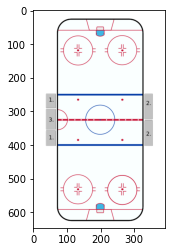

In [257]:
image = Image.open('NHL_Hockey_Rink.png')
imshow(image)

In [258]:
# rotate 
image2 = image.rotate(90, expand=True)
# Crop half rink only
w, h = image2.size
image3 = image2.crop((int(w/2), 0, w, h))
# Trim away additional empty areas with the help of some trial and error
w, h = image3.size
cut_h_upper = 64
cut_h_lower = h - 72
w_new = w - 22
image4 = image3.crop((0, cut_h_upper, w_new, cut_h_lower))

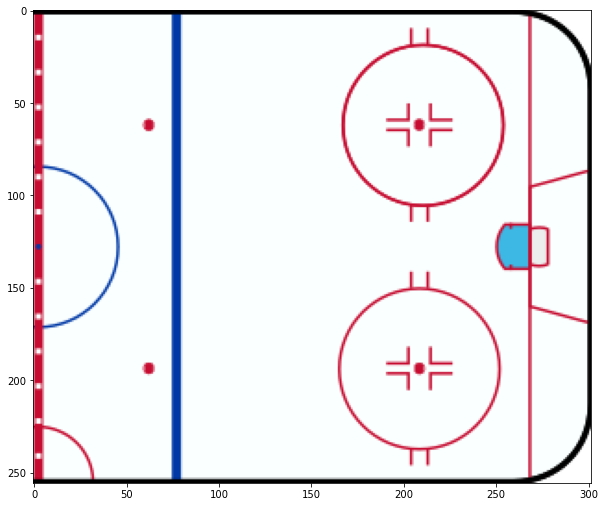

In [259]:
fig=plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.imshow(image4)

In [169]:
w, h = image4.size
print(w, h)

302 256


Calculate some features for McDavid data and also scaled x and y - coordinates to be able to plot it on the imported image

In [174]:
df_mcd["coordinates_x_abs"] = np.abs(df_mcd["coordinates_x"])
df_mcd["coordinates_y_cor"] = np.where(df_mcd["coordinates_x"] < 0, -1*df_mcd["coordinates_y"], df_mcd["coordinates_y"])
df_mcd["x_scaled"] = df_mcd["coordinates_x_abs"] / 100 * w
df_mcd["y_scaled"] = (df_mcd["coordinates_y_cor"] + 42.5) / (2*42.5) * h


df_mcd["distance"] = np.sqrt(df_mcd["coordinates_y_cor"]**2 + (84 - df_mcd["coordinates_x_abs"])**2)
#df_mcd["coordinates_x"] = np.abs(df_mcd["coordinates_x"])
df_mcd["angle"] = np.arctan((84 - df_mcd["coordinates_x_abs"]) * 6 / ((84 - df_mcd["coordinates_x_abs"])**2 + df_mcd["coordinates_y_cor"]**2 - (6/2)**2))
df_mcd["angle"] = np.where(df_mcd["coordinates_x_abs"] >= 84, 0, df_mcd["angle"])
df_mcd["angle2"] = np.arctan((3-np.abs(df_mcd["coordinates_y_cor"]))/(84 - df_mcd["coordinates_x_abs"])) + np.arctan((3+np.abs(df_mcd["coordinates_y_cor"]))/(84 - df_mcd["coordinates_x_abs"]))
df_mcd["angle"] = np.where(np.abs(df_mcd["coordinates_y_cor"]) <= 3, df_mcd["angle2"], df_mcd["angle"])
df_mcd["angle_deg"] = df_mcd["angle"]*180/np.pi
df_mcd["distance_m"] = df_mcd["distance"]*0.3048

df_mcd["goal_angle"] = np.arctan(np.abs(df_mcd["coordinates_y_cor"]) / (84 - df_mcd["coordinates_x_abs"]))
df_mcd["goal_angle_deg"] = df_mcd["goal_angle"] * 180/np.pi

In [176]:
df_mcd.reset_index(drop=True, inplace=True)

Predict XG values for McDavids play data based on previously trained model.

In [178]:
df_mcd["xg"] = test_model.predict(df_mcd[["angle", "distance", "coordinates_x_abs"]])

Lets look at how the distribution of McDavid's XG values year by year. A bit surprising to not see the latest season(21-22) have higner XG values since McDavid has started out extremely well. One option is that the model isnt that good due to lack of additional features based on context. Second option is that the XG values are really low and McDavid is just better than the average XG due to his speed, puck control, shot accuracy, or the "context" he ends up in.

<AxesSubplot:xlabel='year', ylabel='xg'>

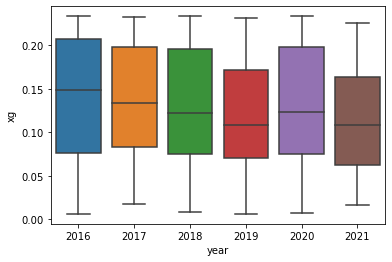

In [224]:
cond = df_mcd["angle_deg"] > 0 
cond2 = df_mcd["result_emptyNet"] != True
sns.boxplot(data=df_mcd[cond & cond2], y="xg", x="year")

Regarding shot's distance from goal it looks like Connor is taking shots further and further away from the goal. This in turn should lead to lower XG values.

<AxesSubplot:xlabel='year', ylabel='distance'>

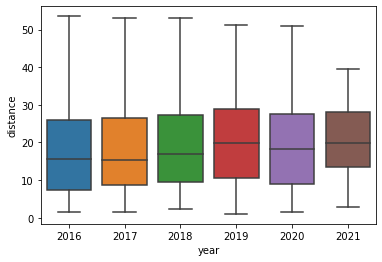

In [251]:
cond = df_mcd["angle_deg"] > 0 
cond2 = df_mcd["result_emptyNet"] != True
sns.boxplot(data=df_mcd[cond & cond2], y="distance", x="year", showfliers=False)

Regarding mouth goal angle it looks like season 21-22 indicates a slight lower angle then previous seasons.

<AxesSubplot:xlabel='year', ylabel='angle_deg'>

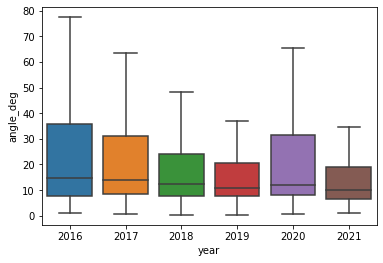

In [266]:
cond = df_mcd["angle_deg"] > 0 
cond2 = df_mcd["result_emptyNet"] != True
sns.boxplot(data=df_mcd[cond & cond2], y="angle_deg", x="year", showfliers=False)
#plt.yscale("log")

Get additional stat values for McDavid for all his NHL seasons.

In [184]:
# Get some player info such as stats
year_list = ["2016", "2017", "2018", "2019", "2020", "2021"]
player = "8478402"
player_mcd_list = []
for year in tqdm(year_list):
    year2 = str(int(year) + 1)
    response = requests.get('https://statsapi.web.nhl.com/api/v1/people/' + player + '/stats/?stats=statsSingleSeason&season=' + year + year2)
    df_player = pd.json_normalize(response.json()["stats"][0]["splits"][0])
    df_player["player_id"] = player
    player_mcd_list.append(df_player)

100%|█████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.97it/s]


In [189]:
df_mcd_stats = pd.concat(player_mcd_list)
df_mcd_stats.reset_index(inplace=True, drop=True)
df_mcd_stats.columns = [col.replace(".", "_") for col in df_mcd_stats.columns]
df_mcd_stats["year"] = df_mcd_stats["season"].str.slice(0,4)
df_mcd_stats["stat_timeOnIce"] = df_mcd_stats["stat_timeOnIce"].str.replace(":",".")
df_mcd_stats["stat_timeOnIce"] = df_mcd_stats["stat_timeOnIce"].astype("float")
df_mcd_stats.head()

,season,stat_timeOnIce,stat_assists,stat_goals,stat_pim,stat_shots,stat_games,stat_hits,stat_powerPlayGoals,stat_powerPlayPoints,stat_powerPlayTimeOnIce,stat_evenTimeOnIce,stat_penaltyMinutes,stat_faceOffPct,stat_shotPct,stat_gameWinningGoals,stat_overTimeGoals,stat_shortHandedGoals,stat_shortHandedPoints,stat_shortHandedTimeOnIce,stat_blocked,stat_plusMinus,stat_points,stat_shifts,stat_timeOnIcePerGame,stat_evenTimeOnIcePerGame,stat_shortHandedTimeOnIcePerGame,stat_powerPlayTimeOnIcePerGame,player_id,year
0,20162017,1732.47,70,30,26,251,82,34,3,27,248:53,1418:05,26,43.17,11.95,6,1,1,2,65:49,29,27,100,1998,21:07,17:17,00:48,03:02,8478402,2016
1,20172018,1767.14,67,41,26,274,82,28,5,20,243:13,1434:45,26,41.36,14.96,7,2,1,4,89:16,46,20,108,1940,21:33,17:29,01:05,02:57,8478402,2017
2,20182019,1781.18,75,41,20,240,78,39,9,33,266:53,1465:37,20,46.62,17.08,9,3,1,2,48:48,30,3,116,1998,22:50,18:47,00:37,03:25,8478402,2018
3,20192020,1399.24,63,34,28,212,64,37,11,43,248:47,1143:56,28,47.76,16.00,6,0,0,0,06:41,18,-6,97,1353,21:51,17:52,00:06,03:53,8478402,2019
4,20202021,1240.36,72,33,20,200,56,61,9,37,234:43,1000:10,20,49.53,16.50,11,2,0,0,05:43,24,21,105,1182,22:09,17:51,00:06,04:11,8478402,2020


Create some additional variables

In [213]:
cond = df_mcd["angle_deg"] > 0 
cond2 = df_mcd["result_emptyNet"] != True
df_mcd_xg = df_mcd[cond & cond2].groupby("year")["xg"].sum().reset_index()
df_mcd_xg = df_mcd_xg.merge(df_mcd_stats[["year", "stat_timeOnIce", "stat_shots", "stat_goals", "stat_games"]], on="year")
df_mcd_xg["xg_norm"] = df_mcd_xg["xg"] / df_mcd_xg["stat_timeOnIce"]
df_mcd_xg["xg_mean"] = df_mcd_xg["xg"] / df_mcd_xg["stat_shots"]
df_mcd_xg["shots_per_time"] = df_mcd_xg["stat_shots"] / df_mcd_xg["stat_timeOnIce"]
df_mcd_xg["shots_per_game"] = df_mcd_xg["stat_shots"] / df_mcd_xg["stat_games"]
df_mcd_xg["time_per_game"] = df_mcd_xg["stat_timeOnIce"] / df_mcd_xg["stat_games"]
df_mcd_xg

,year,xg,stat_timeOnIce,stat_shots,stat_goals,stat_games,xg_norm,xg_mean,shots_per_time,shots_per_game,time_per_game
0,2016,30.423785,1732.47,251,30,82,0.017561,0.121210,0.144880,3.060976,21.127683
1,2017,31.037669,1767.14,274,41,82,0.017564,0.113276,0.155053,3.341463,21.550488
2,2018,25.696713,1781.18,240,41,78,0.014427,0.107070,0.134742,3.076923,22.835641
3,2019,21.686421,1399.24,212,34,64,0.015499,0.102294,0.151511,3.312500,21.863125
4,2020,22.468570,1240.36,200,33,56,0.018115,0.112343,0.161244,3.571429,22.149286
5,2021,4.966384,291.47,56,9,13,0.017039,0.088685,0.192130,4.307692,22.420769


This table also shows lower values for the latest season reagarding both mean and median for "mouth" angle.

In [217]:
df_mcd[cond].groupby("year")["angle_deg"].describe()

,count,mean,std,min,25%,50%,75%,max
year,,,,,,,,
2016,222.0,25.001537,24.778984,0.949567,7.773921,14.835548,35.753887,139.398705
2017,229.0,23.407179,26.084889,0.674698,8.578790,14.036243,30.963757,180.000000
2018,202.0,21.357723,21.767782,0.299453,7.616014,12.352354,25.141109,108.434949
2019,182.0,19.369140,25.233784,0.299453,7.689878,10.963308,20.392061,180.000000
2020,173.0,22.836322,23.789000,0.722177,8.171833,11.840603,30.963757,139.398705
2021,45.0,16.912746,18.276887,0.949567,6.581945,10.091057,20.465863,94.763642


<AxesSubplot:xlabel='goal_angle_deg', ylabel='Density'>

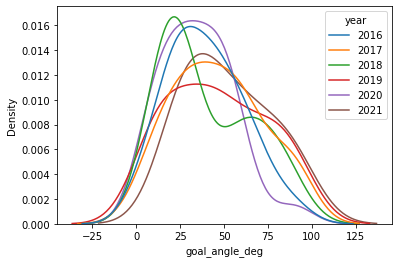

In [219]:
cond = df_mcd["result_event"] == "Goal"
cond2 = df_mcd["goal_angle_deg"] > 0
sns.kdeplot(data=df_mcd[cond & cond2], x="goal_angle_deg", hue="year", common_norm=False)

<AxesSubplot:xlabel='goal_angle_deg', ylabel='Density'>

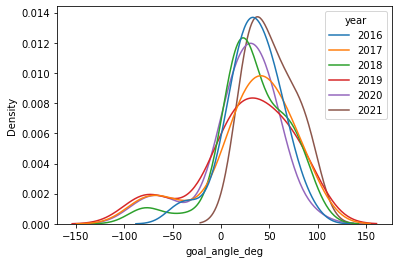

In [220]:
cond = df_mcd["result_event"] == "Goal"
sns.kdeplot(data=df_mcd[cond], x="goal_angle_deg", hue="year", common_norm=False)

(0.0, 50.0)

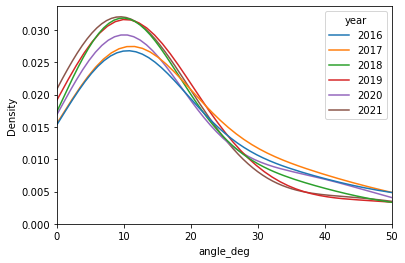

In [269]:
cond = df_mcd["angle_deg"] > 0
sns.kdeplot(data=df_mcd[cond], x="angle_deg", hue="year", common_norm=False)
plt.xlim(0, 50)

McDavid's goals for season 2020 and 2021

<AxesSubplot:xlabel='x_scaled', ylabel='y_scaled'>

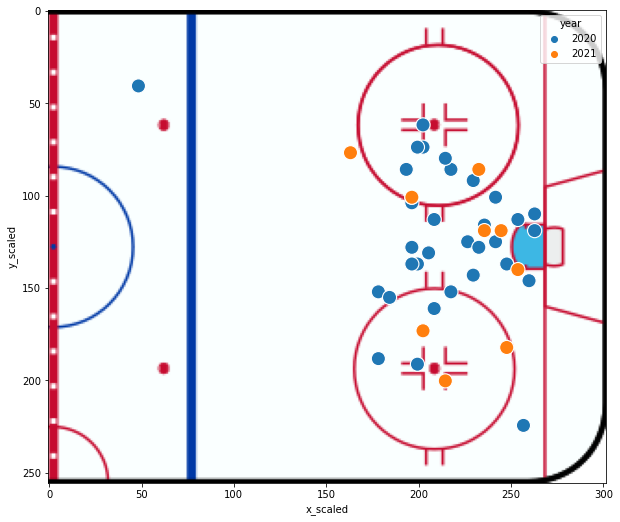

In [278]:
fig=plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
#im = ax.imshow(image4, zorder=1)
#im = plt.imread(image4)
#ax.imshow(im)
ax.imshow(np.array(image4))
#ax.scatter(df_mcd["x_scaled"], df_mcd["y_scaled"], )
cond = df_mcd["result_event"] == "Goal"
cond2 = df_mcd["year"].isin(["2020", "2021"])
sns.scatterplot(data=df_mcd[cond & cond2], x='x_scaled', y='y_scaled', hue='year', ax=ax, s=200)
#sns.scatterplot(data=df_mcd, x='x_scaled', y='y_scaled', hue='year', ax=ax)
#plt.show()
